In [1]:
# Import the necessary libraries
import torch
import utils
import random
import warnings
import numpy as np
from train import train_cgan
warnings.filterwarnings("ignore")
from dataset import ColorizationDataset
from evaluate import evaluate_model, predict
from torch.utils.data import Subset, DataLoader
from models import UNetGenerator, PatchDiscriminator

In [8]:
# Set the random seeds for reproducibility
SEED = 27
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
# Initialize the data paths
DATA_ROOT = "Data"                 # Set this to the root folder of your dataset (modify per user/environment)

l_path = f"{DATA_ROOT}/gray_scale.npy"
ab_paths = [
    f"{DATA_ROOT}/ab/ab1.npy",
    f"{DATA_ROOT}/ab/ab2.npy",
    f"{DATA_ROOT}/ab/ab3.npy",
]

# Load the L (lightness) channel as a memory-mapped array (read on demand from disk)
l_data = np.load(l_path, mmap_mode="r")     # Shape: (25000, 224, 224)

# Load and concatenate the ab (red–green, blue–yellow) channels as memory-mapped arrays
ab_data = [np.load(path, mmap_mode="r") for path in ab_paths]
ab_data = np.concatenate(ab_data, axis=0)   # Shape: (25000, 224, 224, 2)

# Create the datasets
full_train_ds = ColorizationDataset(l_data, ab_data, augment=True)
full_val_ds  = ColorizationDataset(l_data, ab_data, augment=False)

# Split the datasets into training (80%) and validation (20%) sets
N = l_data.shape[0]
idxs = np.random.permutation(N)
train_size = int(0.8 * N)
train_idxs = idxs[:train_size]
val_idxs = idxs[train_size:]
train_dataset = Subset(full_train_ds, train_idxs)
val_dataset  = Subset(full_val_ds,  val_idxs)

# Create the dataloaders for each of the two datasets
BATCH_SIZE = 32
NUM_WORKERS = 2 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

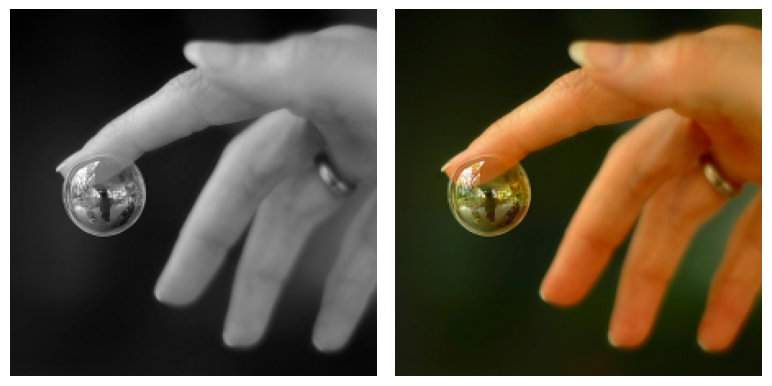

In [ ]:
# Display a sample image from the training dataset
utils.show_image(train_dataset[4164])

In [ ]:
# Create the generator and discriminator models
generator = UNetGenerator()
discriminator = PatchDiscriminator()

In [ ]:
# Determine which device to use (GPU if available, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

In [12]:
# Train the models for 100 epochs
g_losses, d_losses, val_L1_losses, val_PSNR = train_cgan(generator, discriminator, train_loader, val_loader, device, epochs=1, img_sample_idx=18)

KeyboardInterrupt: 

In [ ]:
# Plot the loss curves for the generator and discriminator over the training epochs
utils.plot_gd_losses(g_losses, d_losses)

# Plot the validation L1 loss and PSNR over the training epochs
utils.plot_val_metric(val_L1_losses, metric_name="L1 Loss")
utils.plot_val_metric(val_PSNR, metric_name="PSNR")

In [ ]:
# Load the best model weights for the generator
generator.load_state_dict(torch.load("models/best_generator.pth", map_location=device))

In [ ]:
# Evaluate the final model on the validation set
l1_loss, psnr = evaluate_model(generator, val_loader, device=device)
print(f"Validation L1 Loss: {l1_loss:.4f}, PSNR: {psnr:.2f} dB")

In [ ]:
# Display predicted sample images from the validation set
for i in [69, 30, 87, 40, 769]:
    predict(generator, val_dataset[i], save_path=f"images/sample_{i}")

In [ ]:
gen = UNetGenerator()
gen.load_state_dict(torch.load("best_generator.pth", map_location=device))
gen = gen.to(device)
gen.eval()

L_tensor, rgb_in = utils.prepare_image_for_colorization("test_images/dog.jpg")
rgb_pred = utils.predict_color(gen, L_tensor)

plt.subplot(1,2,1); plt.imshow(rgb_in); plt.title("Input"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(rgb_pred); plt.title("Prediction"); plt.axis("off")
plt.show()